# Lab 3: Stochastic Gradient Descent

The goal of this lab session is to code an optimization algorithm that optimzes the penalized loss function of the logistic regression model.

You have to send the filled notebook named **"L3_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 17, 2019. Please put **"AML-L3"** in the subject. 

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import time

We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [2]:
from sklearn import model_selection

diabetes_data = pd.read_csv("diabetes_data.csv", sep=",")

diabetes_train, diabetes_test = model_selection.train_test_split(diabetes_data)
diabetes_train_x = diabetes_train.iloc[:, :-1].values
diabetes_train_y = diabetes_train.iloc[:, -1].values
diabetes_train_y[diabetes_train_y == 0] = -1

avg = np.mean(diabetes_train_x)
std = np.std(diabetes_train_x) if np.std(diabetes_train_x)!=0 else 1e-3

diabetes_test_x = diabetes_test.iloc[:, :-1].values
diabetes_test_y = diabetes_test.iloc[:, -1].values
diabetes_test_y[diabetes_test_y == 0] = -1

# Normalize the training data and apply the same transforation to the test
diabetes_train_x = (diabetes_train_x - avg)/std
diabetes_test_x = (diabetes_test_x - avg)/std

## Logistic Regression



Today we’ll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$F(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [3]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", C=2, solver='lbfgs') 
start = time.time()
model.fit(diabetes_train_x, diabetes_train_y)
end = time.time()
print("Execution time for sklearn's implementation: {:.3f} seconds".format(end-start))
y_pred = model.predict(diabetes_test_x)

Execution time for sklearn's implementation: 0.038 seconds


and we compute the accuracy score and confusion matrix to evaluate the model performance:

In [4]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(diabetes_test_y, y_pred)
print("Accuracy score for sklearn's implementation:", acc)

Accuracy score for sklearn's implementation: 0.765625


In [5]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix:\n", confusion_matrix(y_true=diabetes_test_y, y_pred=y_pred))

Confusion matrix:
 [[112  17]
 [ 28  35]]


Given that the classes balance is :

In [6]:
stats = np.unique(diabetes_test_y,return_counts=True)
for index in range(len(stats[0])):
    print("Class {0} is represented by {1:.1f}% of the data.".format(stats[0][index],
                                                                     stats[1][index]*100/np.sum(stats[1])))

Class -1 is represented by 67.2% of the data.
Class 1 is represented by 32.8% of the data.


Scikit-learn is pretty good and we will try to reimplement the same algorithm and compare with their results. Notice that even though we reach similar results, sklearn will always be faster by some orders of magnitude... 

### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

The gradient of F is :

$$\nabla F(\textbf{w}) = \sum_{i=1}^n \frac{-y_i*\textbf{x}_i}{1+\exp(y_i\textbf{w}^T\textbf{x}_i)}+\lambda*\textbf{w},$$

Where $\lambda$ is the regularization of the model : it prevents the model from overfitting the data by imposing low values of the model's coefficients.

We can also write F using a decomposition $$F(\textbf{w})=\sum_{i=1}^n f_i(\textbf{w})$$ with $$f_i(\textbf{w})=log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2*n} \| \textbf{w} \|^2,$$

Which rewrites as follow when splitting the data in J mini-batches $B_j$:
$$F(\textbf{w})=\sum_{j=1}^J F_j(\textbf{w})$$
with
$$F_j(\textbf{w})=\sum_{i \in B_j}{log(1+\exp(-y_i\textbf{w}^Tx_i))} \; +\; \frac{\lambda * \# B_j}{2*n} \| \textbf{w} \|^2,$$

### Stochastic Logistic Regression Implementation

In [7]:
class StochasticLogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    tol_: float
        tolerance for the early stopping definition
    max_iter_: integer
        maximum number of iterations to compute in case of non-convergence
    reg_: float
        regularization parameter
    self.has_converged_: boolean
        whether the algorithm has converged or not according to the tolerance set earlier
    lr_: float
        the learning rate
    lr_strategy_: 'inverse' or 'inverse_sigmoid'
        the evolution strategy of the learning rate
    batch_size_: integer >= 1
        the size of the mini-batch
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    intercept: boolean
        whether to use an intercept in our model or not
    """
    def __init__(self, reg, lr=1e-3, batch_size=50, max_iter=500, tol=1e-4, lr_strategy="inverse", 
                 intercept=False):
        self.coef_ = None
        self.tol_ = tol
        self.max_iter_ = max_iter
        self.reg_ = reg
        self.has_converged_ = False
        
        self.lr_ = lr
        self.lr_strategy_ = lr_strategy
        self.batch_size_ = batch_size
        
        self.coef_history_ = []
        self.f_history_ = []
        self.intercept_ = intercept

    def logistic(self, z):
        # logistic function
        return 1/(1+np.exp(-z))
    
    def inverse_lr(self, itr):
        """
        Returns the learning rate to use at the iteration itr.

        The idea is to use a learning rate decreasing according to an inverse function.

        Params:
            itr: the iteration number at which we are
        """
        return self.lr_ / itr
        
    def inverse_sigmoid_lr(self, init, final, max_itr, itr):
        """
        Returns the learning rate to use at the iteration itr.

        The idea is to use a learning rate decreasing according to an inverse sigmoid function.

        Params:
            init: initial value of the learning rate
            final: final value of the learning rate
            max_itr: the number of iterations used in the process
            itr: the iteration number at which we are
        """
        alpha = 2 * (np.log((init-final)/final) - np.log(np.sqrt(init/final)-1)) / max_itr
        beta = np.log((init + final - 2*np.sqrt(init*final))/(init - final))
        return init / (1 + np.exp(alpha*itr+beta))
    
    def gradient(self, coef, batch, X, y):
        """
        Computes the gradient of the logistic loss with a Ridge penalty.
        
        Params:
            coef: the parameters of the logistic regression. The gradient is computed with respect to coef.
            batch: a list of the samples to be considered in the batch
            X: training data
            y: training labels
        """
        n = X.shape[0]
        grad = 0
        
        for sample_idx in batch: # We compute the gradient per mini-batch
            y_i = y[sample_idx]
            x_i = X[sample_idx]
            exp = np.exp(y_i * np.matmul(np.transpose(coef), x_i))
            grad += - y_i * x_i / (1 + exp) + self.reg_*coef / n
            
        return grad
    
    def loss(self, coef, X, y):
        """
        Returns the logistic loss of our model.
        """
        F = 0
        for i in range(X.shape[0]):
            F += np.log(1 + np.exp(-y[i]*np.matmul(np.transpose(X[i]), coef)))

        return F + self.reg_ * 0.5 * np.matmul(np.transpose(coef), coef)
    
    def compute_lr(self, itr, min_lr=1e-5):
        """
        Computes the learning rate at the iteration itr according to the strategy we use.
        """
        if self.lr_strategy_ == "inverse":
            lr = self.inverse_lr(itr)
        elif self.lr_strategy_ == "inverse_sigmoid":
            # self.lr_ will be our initial learning rate and we define the final one as being min_lr.
            lr = self.inverse_sigmoid_lr(init=self.lr_, final=min_lr, max_itr=self.max_iter_, itr=itr-1)
        else: # Then there is no strategy and we use a constant learning rate
            lr = self.lr_
        return lr

    def compute_next_coef(self, X, y, lr, batches, itr):
        """
        Returns the value of the new coef. This function uses a stochastic gradient descent.
        
        Params:
            X: training data
            y: training labels
            lr: learning rate
            batches: a list of the bateches
            itr: the iteration number
        """
        batch=batches[itr%len(batches)]
        return self.coef_ - lr * self.gradient(coef=self.coef_, 
                                               X=X, y=y, 
                                               batch=batch)
    
    def create_batches(self, X):
        """
        Creates the batches corresponding to the training data
        """
        batches = []
        indexes = list(range(X.shape[0]))
        while len(indexes) > 0:
            batch = []
            while len(batch) < self.batch_size_ and len(indexes) > 0:
                i = np.random.randint(low=0,high=len(indexes),size=1)[0]
                batch.append(indexes.pop(i))
            batches.append(batch)
        return batches


    def fit(self, X, y, start):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """        
        if self.intercept_:
            # Let's add the intercept
            X_aug = np.ones((X.shape[0], X.shape[1] + 1))
            X_aug[:, 1:] = X
            X = X_aug
        
        if self.batch_size_ == None:
            self.batch_size_ = X.shape[0]
        self.coef_ = start
        self.coef_history_.append(self.coef_)
        self.f_history_.append(self.loss(coef=self.coef_, X=X, y=y))
        
        # Batches creation
        batches = self.create_batches(X)
        
        itr = 0
        while itr < self.max_iter_ and not self.has_converged_: # critere de convergence
            itr += 1
            
            lr = self.compute_lr(itr)
                
            coef_np1 = self.compute_next_coef(X=X, y=y, lr=lr, batches=batches, itr=itr)
            
            fn = self.f_history_[-1]
            fnp1 = self.loss(X=X, y=y, coef=coef_np1)
            
            if abs(fn - fnp1) <= self.tol_:
                self.has_converged_ = True
            
            # Update the memory
            self.coef_ = coef_np1
            self.coef_history_.append(self.coef_)
            self.f_history_.append(fnp1)
            
         
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (0 or 1)
        """        
        if self.intercept_:
            # Let's add the intercept
            X_aug = np.ones((X.shape[0], X.shape[1] + 1))
            X_aug[:, 1:] = X
            X = X_aug
        
        y_pred = self.logistic(np.matmul(X, self.coef_)) > 0.5
        y_pred = y_pred.astype(int) # y_pred = 0 or 1 according to the probability
        y_pred = y_pred*2 - 1 # the classes are -1 or 1
        
        return y_pred

**Hint** : The maximum value for the stepsize $\theta$ is $$(\frac{1}{4}*\sum_{i=1}^n \| \textbf{x}_i \|^2+\lambda)^{-1}$$

In [8]:
def stepsize_max(alpha):
    stepsize_max = 0
    X = (diabetes_train_x - np.mean(diabetes_train_x)) / (np.std(diabetes_train_x)+1e-3)
    for index in range(len(diabetes_train_x)):
        stepsize_max += np.matmul(np.transpose(X[index]),X[index])
    stepsize_max = 1/(stepsize_max/4 + alpha)
    
    return stepsize_max

for alpha in [10, 1, 1e-1, 1e-2, 1e-3]:
    print("The maximum value of the stepsize for alpha={0} the stepsize is : {1}".format(alpha,
                                                                                         stepsize_max(alpha)))

The maximum value of the stepsize for alpha=10 the stepsize is : 0.0008637790653283629
The maximum value of the stepsize for alpha=1 the stepsize is : 0.0008705467055048136
The maximum value of the stepsize for alpha=0.1 the stepsize is : 0.0008712293067272532
The maximum value of the stepsize for alpha=0.01 the stepsize is : 0.0008712976257296307
The maximum value of the stepsize for alpha=0.001 the stepsize is : 0.0008713044582191824


**Conclusion** : This is all very interesting but as we don't really get where it comes from and because we will use evolving learning rates, we will just keep in mind the global value of ~ 9e-4 and the fact that there might exist a maximal value for the learning rate to converge...

###### Apply to the data

In [9]:
from sklearn.metrics import accuracy_score
my_model = StochasticLogisticRegression(reg=.001, lr=1e-3, batch_size=100, max_iter=2000,
                                        lr_strategy="inverse_sigmoid", tol=0.0001, intercept=True)
# In order to compare with sklearn's implementation, we use the same standard tol
start = time.time()
my_model.fit(diabetes_train_x, diabetes_train_y, start=np.random.rand(diabetes_train_x.shape[1]+1))
end = time.time()

y_pred = my_model.predict(diabetes_test_x)
acc = accuracy_score(diabetes_test_y, y_pred)
print("Accuracy score for our implementation: {:.3f}".format(acc))
print("Our implementation took {0:.3f} seconds and {1} iterations to converge.".format(end-start, 
                                                                                       len(my_model.f_history_)))

Accuracy score for our implementation: 0.750
Our implementation took 9.217 seconds and 720 iterations to converge.


Our result is close to sklearn's one -> Good Enough !

-----------

### Comparing strategies for setting learning rate

A different evolving learning rate that we can use is the following one :

In [2]:
def evolving_lr(init, final, max_itr, itr):
    """
    Returns the learning rate to use at the iteration itr.
    
    The idea is to use a learning rate decreasing according to an inverse sigmoid function.
    
    Params:
        init : initial value of the learning rate
        final : final value of the learning rate
        max_itr : the number of iterations used in the process
        itr : the iteration number at which we are
    """
    alpha = 2 * (np.log((init-final)/final) - np.log(np.sqrt(init/final)-1)) / max_itr
    beta = np.log((init + final - 2*np.sqrt(init*final))/(init - final))
    return init / (1 + np.exp(alpha*itr+beta))

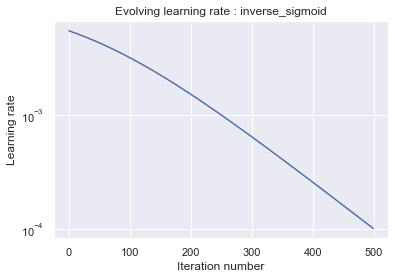

In [3]:
init = 1e-2
final = 1e-4
max_itr = 500
lr = []
for itr in range(max_itr):
    lr.append(evolving_lr(init, final, max_itr, itr))
    
plt.plot([itr for itr in range(max_itr)],lr)
plt.yscale('log')
plt.title('Evolving learning rate : inverse_sigmoid')
plt.xlabel('Iteration number')
plt.ylabel('Learning rate')
plt.show()

Or simply use an inverse learning rate : $$lr = \frac{Constant}{iteration}$$

In [12]:
batch_size = 100
predictions = {}
loss_history = {}

for strat in ["inverse", "inverse_sigmoid"]:
    model = StochasticLogisticRegression(reg=1, lr=0.01,
                                         batch_size=batch_size, 
                                         max_iter=1500, tol=0.001, 
                                         lr_strategy=strat, intercept=False)
    model.fit(diabetes_train_x, diabetes_train_y, start=np.random.rand(diabetes_train_x.shape[1]))
    predictions[strat] = model.predict(diabetes_test_x)
    loss_history[strat] = model.f_history_
    
model = StochasticLogisticRegression(reg=1, lr=0.0008,
                                     batch_size=batch_size, 
                                     max_iter=1500, tol=0.001, 
                                     lr_strategy='constant', intercept=False)
model.fit(diabetes_train_x, diabetes_train_y, start=np.random.rand(diabetes_train_x.shape[1]))
predictions['constant'] = model.predict(diabetes_test_x)
loss_history['constant'] = model.f_history_

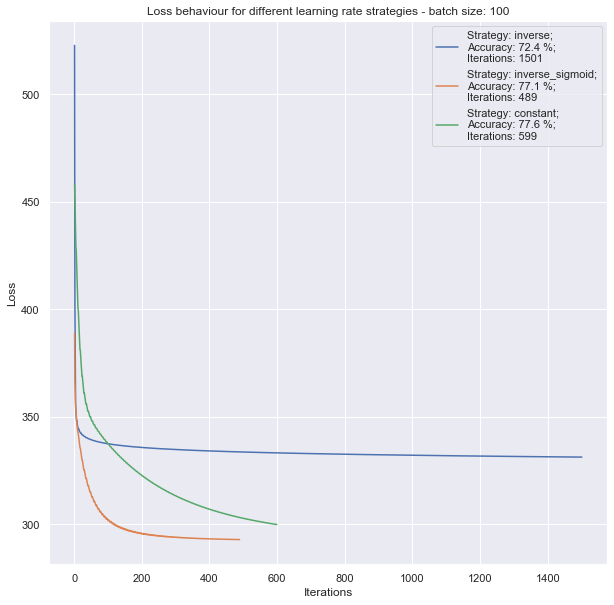

In [13]:
plt.figure(figsize=(10,10))

for strategy, y_pred in predictions.items():
    plt.plot([i for i in range(1,len(loss_history[strategy])+1)], 
             loss_history[strategy], 
             label="Strategy: {};\nAccuracy: {:.1f} %;\nIterations: {}".format(strategy,
                                                                              accuracy_score(diabetes_test_y,
                                                                                             y_pred)*100,
                                                                              len(loss_history[strategy])))
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss behaviour for different learning rate strategies - batch size: "+str(batch_size))
plt.show()

**Conclusion** : It seems that the *inverse_sigmoid* strategy for the learning rate yields better results than the usual one. In addition it converges so much faster !

-----------

Let's now focus on averaging techniques. Keep in mind that two types of averagings have been seen during the lesson :
 - Averaging the coefficients (optimize the solution)
 - Averaging the gradients (accelerated variant of the convergence)

### Averaging the coefficients

In [14]:
class StochasticAverageLogisticRegression(StochasticLogisticRegression):
    def compute_lr(self, itr, min_lr=1e-5):
        lr = max(self.lr_ / itr**0.75, min_lr)
        return lr
        
    def compute_next_coef(self, X, y, lr, batches, itr):
        batch=batches[itr%len(batches)]
        coef_np1 = self.coef_ - lr * self.gradient(coef=self.coef_, 
                                                   X=X, y=y,
                                                   batch=batch)

        # A technique of averaging the coefficients can be considered
        coef_np1 = (1 - 1/itr)*self.coef_history_[-1] + coef_np1 / itr
        return coef_np1

In [15]:
from sklearn.metrics import accuracy_score
my_averaged_model = StochasticAverageLogisticRegression(reg=.001, lr=0.01, batch_size=None, max_iter=2000,
                                                        tol=0.0001, lr_strategy='inverse_sigmoid')
start = time.time()
my_averaged_model.fit(diabetes_train_x, diabetes_train_y, start=np.random.rand(diabetes_train_x.shape[1]))
end = time.time()

y_pred = my_averaged_model.predict(diabetes_test_x)
acc = accuracy_score(diabetes_test_y, y_pred)
print("Accuracy score for our implementation when averaging: {:.3f}".format(acc))
print("Our implementation when averaging took {0:.3f} seconds and {1} iterations to converge.".format(end-start,
                                                                            len(my_averaged_model.f_history_)))

Accuracy score for our implementation when averaging: 0.760
Our implementation when averaging took 19.470 seconds and 723 iterations to converge.


###### Plot the convergence with respect to the batch size - with and without averaging

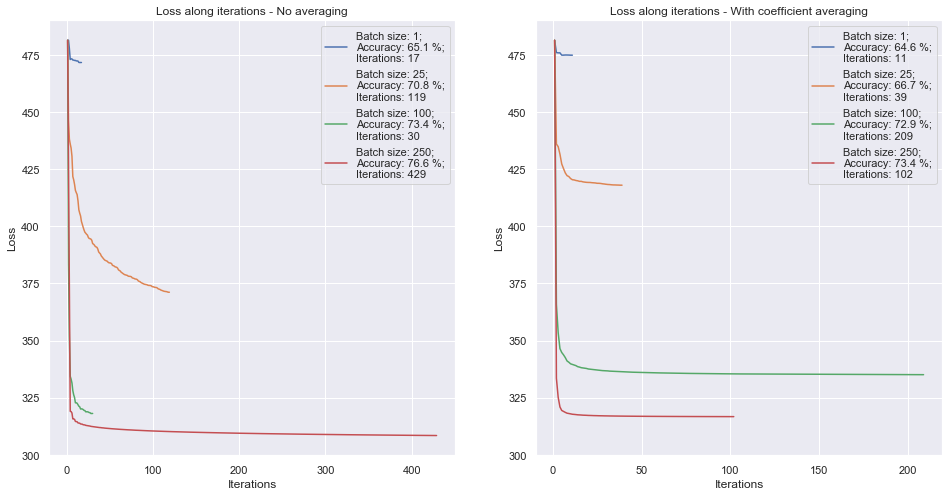

In [16]:
from sklearn.metrics import accuracy_score

batch_sizes = [1,25,100,250]
init_args = dict(reg=1, lr=0.01, max_iter=500, tol=0.001)
fit_args= dict(X=diabetes_train_x, y=diabetes_train_y, start=np.ones(shape=(diabetes_train_x.shape[1])))

plt.figure(figsize=(16,8))

ax = plt.subplot(121)
for batch_size in batch_sizes:
    my_model = StochasticLogisticRegression(**init_args, batch_size=batch_size) 
    my_model.fit(**fit_args)
    y_pred = my_model.predict(diabetes_test_x)
    plt.plot([i for i in range(1,len(my_model.f_history_)+1)], 
             my_model.f_history_, 
             label="Batch size: {};\nAccuracy: {:.1f} %;\nIterations: {}".format(batch_size,
                                                                              accuracy_score(diabetes_test_y,
                                                                                             y_pred)*100,
                                                                              len(my_model.f_history_)))
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss along iterations - No averaging")

plt.subplot(122, sharey=ax)
for batch_size in batch_sizes:
    my_model = StochasticAverageLogisticRegression(**init_args, batch_size=batch_size) 
    my_model.fit(**fit_args)
    y_pred = my_model.predict(diabetes_test_x)
    plt.plot([i for i in range(1,len(my_model.f_history_)+1)], 
             my_model.f_history_, 
             label="Batch size: {};\nAccuracy: {:.1f} %;\nIterations: {}".format(batch_size,
                                                                              accuracy_score(diabetes_test_y, y_pred)*100,
                                                                              len(my_model.f_history_)))
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss along iterations - With coefficient averaging")
plt.show()

**Conclusion** : Averaging the coefficients effectively **improves the speed** of convergence of the algorithm, but the final loss and accuracy are **not as good** as without averaging.

### Accelerated Variants

In [17]:
class AcceleratedStochasticLogisticRegression(StochasticLogisticRegression):
    def __init__(self, acc_type='SAG', **kwargs):
        """
        phi_: List
            phi[index] are the last evaluated coefficients for batch=batches[index]
            This is somehow a memory that will be used to compute the batch-wise momentum.
        acc_type_: str, one of 'SAG' or 'SAGA'
            the averaged acceleration method that will be used
        """
        super().__init__(**kwargs)
        self.phi_ = []
        self.acc_type_ = acc_type
        self.grad_sum_ = 0

    def create_batches(self, X):
        batches = super().create_batches(X)
        self.phi_ = [self.coef_] * len(batches)
        return batches
    
    def compute_lr(self, itr, min_lr=1e-5):
        lr = max(self.lr_ / itr, min_lr)
        return lr
    
    def compute_next_coef(self, X, y, lr, batches, itr):
        grad_phi = 0
        for index in range(len(batches)):
            # Let's compute the gradient of phi on each batch
            grad_phi += self.gradient(coef=self.phi_[index], 
                                      X=X, y=y,
                                      batch=batches[index])

        additional_term = (self.gradient(coef=self.coef_,X=X, y=y,
                                              batch=batches[itr%len(batches)]) - 
                                self.gradient(coef=self.phi_[itr%len(self.phi_)],X=X, y=y,
                                              batch=batches[itr%len(batches)]))

        if self.acc_type_=='SAG':
            coef_np1 = self.coef_ - lr * (grad_phi - additional_term)/X.shape[0]
        elif self.acc_type_=='SAGA':
            coef_np1 = self.coef_ - lr * (grad_phi/X.shape[0] - additional_term)
        else: # Then self.acc_type_ is None
            coef_np1 = self.coef_ - lr * self.gradient(coef=self.coef_, 
                                                       X=X, y=y,
                                                       batch=batches[itr%len(batches)])
        
        self.phi_[itr%len(self.phi_)] = self.coef_
        return coef_np1

**ADAM Method**

One very popular optimization nowadays is ADAM (Adaptive Moment Estimation), introduced by  Diederik, Kingma; Ba, Jimmy in 2014.

The idea is to update the learning rate at each iteration by a coefficient depending on the averages of the gradient and it's second order moment.


At each iteration, we update the coefficients $\beta$ of the Logistic regression as follows:

$$\beta^{(t + 1)} \leftarrow \beta^{(t)} - \eta \frac{\hat{m}_{\beta}}{\sqrt{\hat{v_{\beta}}} + \epsilon}$$

with $\epsilon > 0$ a small positive constant (to avoid disvision by zero) and:

$$\hat{m}_{\beta} = \frac{m_{\beta}^{(t +1)}}{ 1 - (f_1)^{t + 1}}$$

$$\hat{v}_{\beta} = \frac{v_{\beta}^{(t +1)}}{ 1 - (f_2)^{t + 1}}$$

$f_1$ and $f_2$ are called the forgetting factors and $m_{\beta}$ and $v_{\beta}$ are defined as follow:


$$m_{\beta}^{(t + 1)} \leftarrow f_1 m_{\beta}^{(t)} + (1 -  f_1) \nabla_{\beta}L^{(t)}$$

$$v_{\beta}^{(t + 1)} \leftarrow f_2 v_{\beta}^{(t)} + (1 -  f_2) (\nabla_{\beta}L^{(t)})^2$$

L being the Loss function.

In [18]:
class ADAM(StochasticLogisticRegression):
    def __init__(self, f1=None, f2=None, **kwargs):
        # Forgetting factors
        self.f1_ = f1
        self.f2_ = f2
        
        # Coefficients
        self.m_ = [1]
        self.v_ = [1]
        super().__init__(**kwargs)
    
    def compute_lr(self, itr, min_lr=1e-5):
        return self.lr_
    
    def compute_next_coef(self, X, y, lr, batches, itr):
        gradient = self.gradient(coef=self.coef_, X=X, y=y,
                                 batch=batches[itr%len(batches)])

        mnp1 = self.f1_ * self.m_[-1] + (1 - self.f1_) * gradient
        vnp1 = self.f2_ * self.v_[-1] + (1 - self.f2_) * (gradient**2)

        self.m_.append(mnp1)
        self.v_.append(vnp1)

        m = mnp1 / (1 - self.f2_**(itr + 1))
        v = vnp1 / (1 - self.f1_**(itr + 1))
        
        coef_np1 = self.coef_ - lr * mnp1 / (np.sqrt(vnp1) + 1e-7)

        return coef_np1

Accuracy score for SAGA method: 0.6979
Our implementation of SAGA took 70.559 seconds and 2001 iterations to converge.


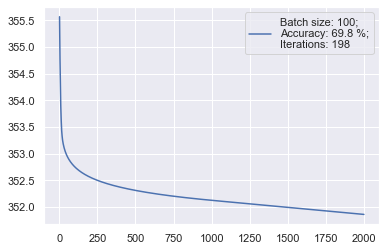

In [22]:
from sklearn.metrics import accuracy_score
batch_size = 100

my_accelerated_model = AcceleratedStochasticLogisticRegression(reg=.001, lr=0.01, max_iter=2000, tol=0.0001,
                                                               acc_type='SAGA', batch_size=batch_size)
start = time.time()
my_accelerated_model.fit(diabetes_train_x, diabetes_train_y, start=np.random.rand(diabetes_train_x.shape[1]))
end = time.time()
y_pred = my_accelerated_model.predict(diabetes_test_x)
acc = accuracy_score(diabetes_test_y, y_pred)
print("Accuracy score for SAGA method: {:.4f}".format(acc))
print("Our implementation of SAGA took {:.3f} seconds and {} iterations to converge.".format(float(end-start), 
                                                                    len(my_accelerated_model.f_history_)))

plt.plot([i for i in range(1,len(my_accelerated_model.f_history_)+1)], 
             my_accelerated_model.f_history_, 
             label="Batch size: {};\nAccuracy: {:.1f} %;\nIterations: {}".format(batch_size,
                                                                                  accuracy_score(diabetes_test_y, y_pred)*100,
                                                                                  len(my_model.f_history_)))
plt.legend()
plt.show()


###### Let's plot the losses of the different accelerated methods

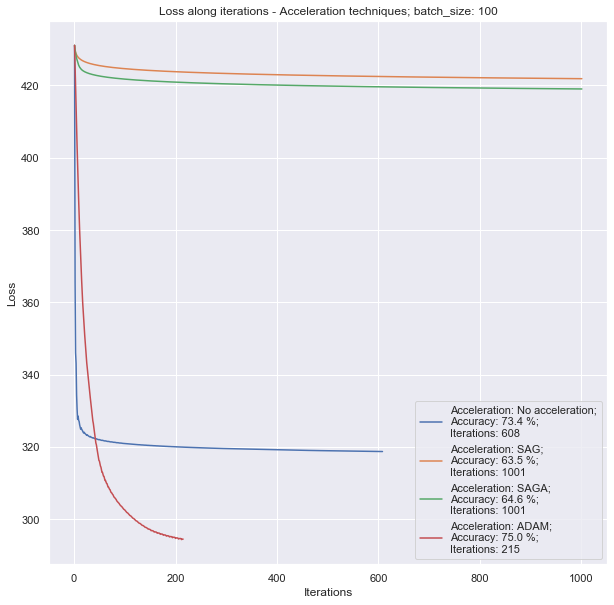

In [23]:
from sklearn.metrics import accuracy_score
plt.figure(figsize=(10,10))

batch_size = 100
init_args = dict(reg=1, lr=0.01, max_iter=1000, tol=0.001, batch_size=batch_size)
fit_args = dict(X=diabetes_train_x, y=diabetes_train_y, start=np.random.rand(diabetes_train_x.shape[1]))

for acc_type in [None, 'SAG', 'SAGA']:
    my_model = AcceleratedStochasticLogisticRegression(**init_args, acc_type=acc_type) 
    my_model.fit(**fit_args)
    y_pred = my_model.predict(diabetes_test_x)
    plt.plot([i for i in range(1,len(my_model.f_history_)+1)], 
             my_model.f_history_, 
             label="Acceleration: {};\nAccuracy: {:.1f} %;\nIterations: {}".format(acc_type if acc_type else "No acceleration",
                                                                                 accuracy_score(diabetes_test_y, y_pred)*100,
                                                                                 len(my_model.f_history_)))


# ADAM
adam = ADAM(**init_args, f1=0.1, f2=0.1)
adam.fit(**fit_args)
y_pred = adam.predict(diabetes_test_x)
plt.plot([i for i in range(1,len(adam.f_history_)+1)], 
         adam.f_history_, 
         label="Acceleration: {};\nAccuracy: {:.1f} %;\nIterations: {}".format("ADAM",
                                                                             accuracy_score(diabetes_test_y, y_pred)*100,
                                                                             len(adam.f_history_)))
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss along iterations - Acceleration techniques; batch_size: {}".format(batch_size))
plt.show()

**Comments:**

Surpisingly the SAG and SAGA accelerated methods do not converge faster !

However, the ADAM method (ADaptive Moment Estimation - Diederik P. Kingma and Jimmy Ba, 2014) converges quite fast towards a better optimum. This explains why everybody is using it !


What could be interesting to look at to go further is the validation loss of each of our methods and cross validation.